In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("telco_churn_data.csv")
print(df.head())
print(df.info())
print(df.isnull().sum())


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [ ]:

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True) #converting TotalCharge column to numeric values and making other objects as Nan if can't be converted


/tmp/ipython-input-3137982545.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


/tmp/ipython-input-183581466.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Churn"]=="Yes"]["MonthlyCharges"], label="Churned", shade=True)
/tmp/ipython-input-183581466.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Churn"]=="No"]["MonthlyCharges"], label="No Churned yet", shade=True)


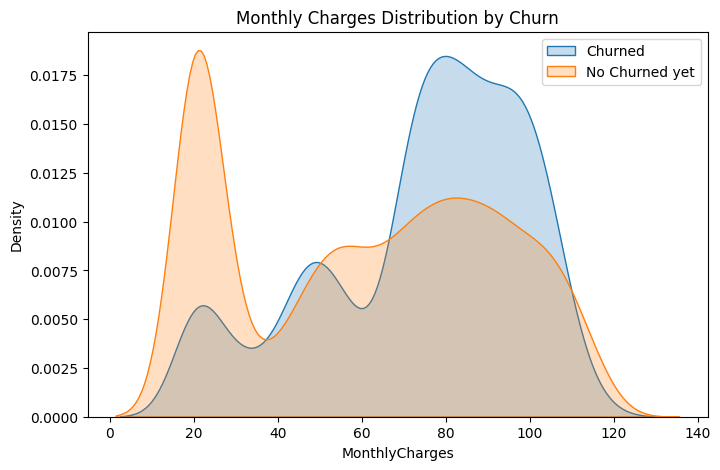

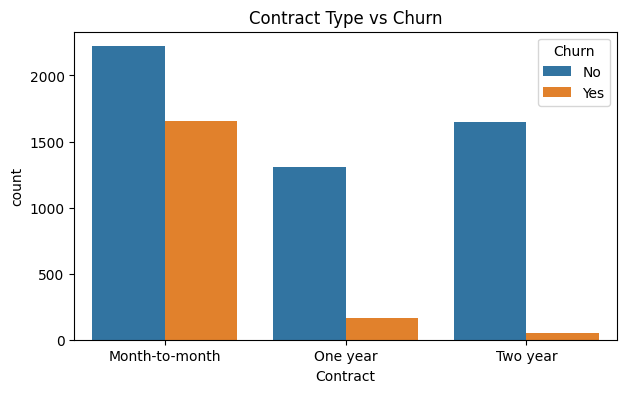

In [7]:

plt.figure(figsize=(8,5))
sns.kdeplot(df[df["Churn"]=="Yes"]["MonthlyCharges"], label="Churned", shade=True)
sns.kdeplot(df[df["Churn"]=="No"]["MonthlyCharges"], label="No Churned yet", shade=True)
plt.legend(); plt.title("Monthly Charges Distribution by Churn"); plt.show()
#plotting KDE graph that shows the distribution of Monthly Charges for two groups customers who churned and those who did not churn.
#blue line shows customer who left and were having high montly bills
#red line show customer who are still using the service



plt.figure(figsize=(7,4))
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Contract Type vs Churn"); plt.show()
#count plot shows the type of subscription used from the categories of churned vs not churned


In [9]:

df["AvgMonthlySpend"] = df["TotalCharges"] / (df["tenure"].replace(0,1))
df["IsLongTermContract"] = df["Contract"].apply(lambda x: 1 if "Two year" in x else 0)
#creating two new columns 1. AvgMonthlySpend and 2. IsLongTermContract (if Two years)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression


X = df.drop(columns=["Churn","customerID","Timestamp"], errors="ignore")
y = df["Churn"].map({"Yes":1,"No":0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


num_features = X.select_dtypes(include=["int64","float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns


num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])


pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)


In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    pipe.fit(X_train, y_train)
    print(f"{name} Train Score:", pipe.score(X_train, y_train))
    print(f"{name} Test Score:", pipe.score(X_test, y_test))

# Hyperparameter tuning on RandomForest
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [5, 10, None]
}

rf_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier())
])

grid = GridSearchCV(rf_pipe, param_grid, scoring="f1_weighted", cv=5)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_


LogisticRegression Train Score: 0.7529286474973376
LogisticRegression Test Score: 0.7409510290986515
RandomForest Train Score: 0.9980475683351083
RandomForest Test Score: 0.7821149751596878
GradientBoosting Train Score: 0.8296059637912673
GradientBoosting Test Score: 0.7991483321504613
Best Params: {'classifier__max_depth': 10, 'classifier__n_estimators': 200}


In [12]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, roc_auc_score

# Pipeline with SMOTE + best RandomForest
smote_pipe = ImbPipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(
        n_estimators=200, max_depth=10, random_state=42
    ))
])

smote_pipe.fit(X_train, y_train)

# Compare with and without imbalance handling
# --- Without imbalance handling (best tuned RF) ---
y_pred_no = best_model.predict(X_test)
y_prob_no = best_model.predict_proba(X_test)[:,1]

f1_no = f1_score(y_test, y_pred_no, average="weighted")
roc_no = roc_auc_score(y_test, y_prob_no)

# --- With imbalance handling (SMOTE) ---
y_pred_smote = smote_pipe.predict(X_test)
y_prob_smote = smote_pipe.predict_proba(X_test)[:,1]

f1_smote = f1_score(y_test, y_pred_smote, average="weighted")
roc_smote = roc_auc_score(y_test, y_prob_smote)

print("📊 Performance Comparison")
print(f"Without imbalance handling → F1: {f1_no:.3f}, ROC AUC: {roc_no:.3f}")
print(f"With SMOTE oversampling   → F1: {f1_smote:.3f}, ROC AUC: {roc_smote:.3f}")


📊 Performance Comparison
Without imbalance handling → F1: 0.795, ROC AUC: 0.839
With SMOTE oversampling   → F1: 0.774, ROC AUC: 0.835


The performance didn't improve as SMOTE can somethimes induce noise, which leads to confusion in the model and making it harder to learn. Generating more minority samples within this overlapped region can increase the confusion for the model, making it even harder to find a clear separation. An f1 score of 0.795 and a roc auc of 0.839 can be good considered good and the model were already capable of handling class imbalance.


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      1035
           1       0.55      0.69      0.61       374

    accuracy                           0.77      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.77      0.77      1409

ROC AUC: 0.8353444935286368


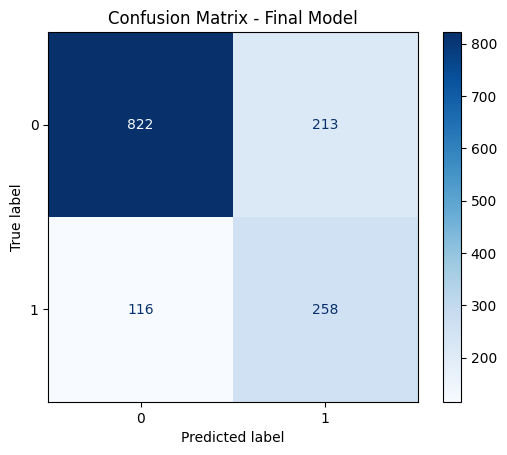

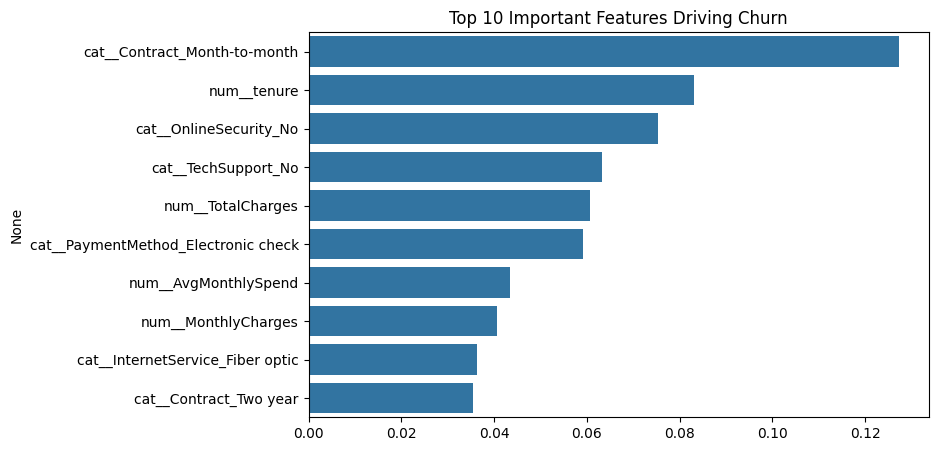

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


y_pred = smote_pipe.predict(X_test)
y_prob = smote_pipe.predict_proba(X_test)[:,1]


print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Confusion Matrix - Final Model")
plt.show()


importances = smote_pipe.named_steps["classifier"].feature_importances_
feature_names = smote_pipe.named_steps["preprocessor"].get_feature_names_out()

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 10 Important Features Driving Churn")
plt.show()


when we are trying to predict who is leaving or churn, a False Positive (saying a customer will leave when they actually stay) just costs the business some money on unneeded discounts, which is a pretty manageable expense. But a False Negative (predicting a customer will stay when they actually churn) is way more costly cause you lose a whole customer and their long-term money so False Negatives are much worse.

When we use a tree-based model like Random Forest, the top 10 most important features usually highlights things like Contract type, Tenure, MonthlyCharges, TotalCharges, InternetService, and how they pay. It just shows that customers with short-term deals, higher bills, and less stable service are more likely to leave, while folks with long-term commitments and affordable, regular bills are going to remain.